In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np
from nff.io.ase_calcs import NeuralFF

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.misc import get_atoms_batch
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
/home/dux/miniforge3/envs/vssr-mc/lib/python3.11/site-packages/models


Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3_001"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)
logging.getLogger(
    "matplotlib.font_manager"
).disabled = True  # disable matplotlib font manager logging

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/SrTiO3_001/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [4]:
import torch
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/SrTiO3_001/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

10:44:09 - mcmc.calculators | INFO: chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
10:44:09 - mcmc.calculators | INFO: offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


{'calc_name': 'NFF',
 'optimizer': 'BFGS',
 'chem_pots': {'Sr': -2, 'Ti': 0, 'O': 0},
 'relax_atoms': True,
 'relax_steps': 20,
 'offset': True,
 'offset_data': {'bulk_energies': {'O': -0.17747231201,
   'Sr': -0.06043637668,
   'SrTiO3': -1.470008697358702},
  'stoidict': {'Sr': 0.49995161381315867,
   'Ti': -0.0637500349111578,
   'O': -0.31241304903276834,
   'offset': -11.324476454433157},
  'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
  'ref_formula': 'SrTiO3',
  'ref_element': 'Ti'}}

Initialize surface system

In [5]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

10:44:09 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3_001', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
10:44:09 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
10:44:09 - mcmc.system | INFO: Initializing 64 virtual atoms
10:44:09 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10:44:09 - mcmc.system | INFO: Number of pristine atoms is 60
10:44:09 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
10:44:09 - mcmc.

      Step     Time          Energy          fmax
BFGS:    0 10:44:10     -467.521881        0.204407
BFGS:    1 10:44:10     -467.525757        0.180273
BFGS:    2 10:44:10     -467.540619        0.079328
BFGS:    3 10:44:11     -467.540924        0.059825
BFGS:    4 10:44:11     -467.541351        0.005868


Calculate pristine surface energy

In [6]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [7]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

10:44:11 - mcmc.mcmc | INFO: Using run folder SrTiO3_001
10:44:11 - mcmc.mcmc | INFO: There are 60 atoms in pristine slab
10:44:11 - mcmc.mcmc | INFO: Running with total_sweeps = 10, sweep_size = 5, start_temp = 1.000
10:44:11 - mcmc.mcmc | INFO: Starting with iteration 0
10:44:11 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
10:44:11 - mcmc.mcmc | INFO: In sweep 1 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:44:11     -468.395111        0.434631
BFGS:    1 10:44:12     -468.405975        0.409606
BFGS:    2 10:44:13     -468.507538        0.787992
BFGS:    3 10:44:13     -468.527954        0.761691
BFGS:    4 10:44:14     -468.575165        0.779738
BFGS:    5 10:44:14     -468.753082        1.728111
BFGS:    6 10:44:15     -469.413422        3.994919
BFGS:    7 10:44:16     -470.350983        2.500931
BFGS:    8 10:44:16     -470.411469        2.776969
BFGS:    9 10:44:17     -470.588348        0.756475
BFGS:   10 10:44:17     -470.627289        0.749382
BFGS:   11 10:44:18     -470.876617        0.812617
BFGS:   12 10:44:18     -470.936615        0.822429
BFGS:   13 10:44:19     -471.098755        0.697925
BFGS:   14 10:44:19     -471.217621        0.616879
BFGS:   15 10:44:20     -471.304779        0.642711
BFGS:   16 10:44:20     -471.344879        0.647994
BFGS:   17 10:44:20     -471.372650        0.447758
BFGS:   18 10:

10:45:05 - mcmc.system | INFO: Optimized structure has surface energy = 11.068
10:45:05 - mcmc.mcmc | INFO: In sweep 2 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:45:05     -454.894623      103.248789
BFGS:    1 10:45:06     -459.571533       57.165066
BFGS:    2 10:45:06     -470.854736       23.795123
BFGS:    3 10:45:07     -475.705902        8.624444
BFGS:    4 10:45:07     -476.887299        5.682622
BFGS:    5 10:45:08     -478.036011        4.089357
BFGS:    6 10:45:08     -478.904144        3.843796
BFGS:    7 10:45:09     -479.329926        2.451557
BFGS:    8 10:45:09     -479.600067        2.101280
BFGS:    9 10:45:10     -479.921783        1.344684
BFGS:   10 10:45:10     -480.010498        2.063681
BFGS:   11 10:45:11     -480.192841        1.375783
BFGS:   12 10:45:12     -480.323486        1.302791
BFGS:   13 10:45:13     -480.405151        1.400565
BFGS:   14 10:45:13     -480.561188        1.442881
BFGS:   15 10:45:14     -480.698090        2.098230
BFGS:   16 10:45:14     -480.938873        2.206647
BFGS:   17 10:45:15     -481.204987        1.618916
BFGS:   18 10:

10:45:55 - mcmc.system | INFO: Optimized structure has surface energy = 12.128
10:45:55 - mcmc.mcmc | INFO: In sweep 3 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:45:55     -422.826904      103.720610
BFGS:    1 10:45:56     -444.607513       59.896036
BFGS:    2 10:45:56     -461.141205       36.954904
BFGS:    3 10:45:56     -473.601227       16.681823
BFGS:    4 10:45:57     -479.115326        9.552298
BFGS:    5 10:45:57     -482.039825        4.586820
BFGS:    6 10:45:57     -483.540985        3.516892
BFGS:    7 10:45:58     -484.562897        2.585065
BFGS:    8 10:45:58     -485.337402        2.477193
BFGS:    9 10:45:59     -485.890350        2.664430
BFGS:   10 10:45:59     -486.360809        2.566633
BFGS:   11 10:45:59     -487.077240        2.280322
BFGS:   12 10:46:00     -487.355133        2.247209
BFGS:   13 10:46:00     -487.957245        2.814762
BFGS:   14 10:46:01     -488.610321        3.167074
BFGS:   15 10:46:01     -489.257050        3.131399
BFGS:   16 10:46:02     -489.856934        3.130917
BFGS:   17 10:46:02     -490.503754        2.485275
BFGS:   18 10:

10:46:40 - mcmc.system | INFO: Optimized structure has surface energy = 12.128
10:46:40 - mcmc.mcmc | INFO: In sweep 4 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:46:41     -444.665314      100.109081
BFGS:    1 10:46:41     -454.537445       58.183268
BFGS:    2 10:46:42     -468.828979       22.348236
BFGS:    3 10:46:42     -477.978882       11.320829
BFGS:    4 10:46:43     -482.083954        4.798074
BFGS:    5 10:46:44     -484.342407        4.049606
BFGS:    6 10:46:45     -485.867340        4.644741
BFGS:    7 10:46:45     -486.968262        5.217257
BFGS:    8 10:46:46     -487.786377        5.678372
BFGS:    9 10:46:47     -488.644562        5.297215
BFGS:   10 10:46:47     -489.583252        3.986830
BFGS:   11 10:46:48     -490.341339        2.641091
BFGS:   12 10:46:49     -490.949371        2.186848
BFGS:   13 10:46:49     -491.531464        2.198248
BFGS:   14 10:46:50     -492.043793        2.487067
BFGS:   15 10:46:51     -492.597992        2.616905
BFGS:   16 10:46:51     -493.203522        1.860106
BFGS:   17 10:46:52     -493.697876        1.800218
BFGS:   18 10:

10:47:41 - mcmc.system | INFO: Optimized structure has surface energy = 2.282
10:47:41 - mcmc.mcmc | INFO: In sweep 5 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:47:41     -446.915131      104.903257
BFGS:    1 10:47:42     -457.796234       57.488667
BFGS:    2 10:47:43     -474.578766       23.982942
BFGS:    3 10:47:44     -484.573242       14.506595
BFGS:    4 10:47:45     -491.404541        8.474020
BFGS:    5 10:47:45     -496.039154        6.169827
BFGS:    6 10:47:47     -499.823486        6.298710
BFGS:    7 10:47:47     -502.780884        6.206560
BFGS:    8 10:47:48     -504.239471        6.030733
BFGS:    9 10:47:49     -504.991241        3.605886
BFGS:   10 10:47:50     -506.092926        3.188362
BFGS:   11 10:47:51     -506.784210        3.098499
BFGS:   12 10:47:51     -507.531738        3.871080
BFGS:   13 10:47:52     -508.717529        4.404973
BFGS:   14 10:47:52     -509.718140        3.564786
BFGS:   15 10:47:53     -510.535431        3.297400
BFGS:   16 10:47:54     -511.578094        4.680247
BFGS:   17 10:47:54     -512.618164        3.395690
BFGS:   18 10:

10:48:48 - mcmc.system | INFO: Optimized structure has surface energy = 2.282
10:48:48 - mcmc.mcmc | INFO: In sweep 6 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:48:48     -455.801788      130.250637
BFGS:    1 10:48:49     -472.420166       30.092142
BFGS:    2 10:48:49     -484.723114       25.350418
BFGS:    3 10:48:50     -493.174835       13.850847
BFGS:    4 10:48:50     -499.354980        6.117179
BFGS:    5 10:48:51     -503.312622        4.080468
BFGS:    6 10:48:52     -505.959839        2.802797
BFGS:    7 10:48:52     -507.785187        3.586809
BFGS:    8 10:48:53     -509.180664        4.198956
BFGS:    9 10:48:54     -510.330566        4.353857
BFGS:   10 10:48:54     -511.565887        4.454135
BFGS:   11 10:48:55     -512.952698        5.268149
BFGS:   12 10:48:56     -514.440247        5.478114
BFGS:   13 10:48:57     -517.290039        4.331315
BFGS:   14 10:48:57     -518.337830        3.408252
BFGS:   15 10:48:57     -519.038513        3.334425
BFGS:   16 10:48:58     -520.485901        2.346313
BFGS:   17 10:48:59     -520.839966        2.406691
BFGS:   18 10:

10:49:50 - mcmc.system | INFO: Optimized structure has surface energy = 2.282
10:49:50 - mcmc.mcmc | INFO: In sweep 7 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:49:50     -448.555634       95.353874
BFGS:    1 10:49:50     -459.043854       60.610402
BFGS:    2 10:49:51     -473.878906       24.290839
BFGS:    3 10:49:52     -483.324493       11.719985
BFGS:    4 10:49:53     -489.523651        7.179145
BFGS:    5 10:49:53     -493.899261        4.930386
BFGS:    6 10:49:54     -496.783783        3.887901
BFGS:    7 10:49:55     -498.528473        5.234327
BFGS:    8 10:49:55     -500.108612        4.498061
BFGS:    9 10:49:56     -501.459259        2.830675
BFGS:   10 10:49:57     -502.611328        3.225860
BFGS:   11 10:49:57     -503.877075        3.526555
BFGS:   12 10:49:58     -505.345551        2.742258
BFGS:   13 10:49:58     -506.349854        2.780585
BFGS:   14 10:49:59     -507.482513        2.750082
BFGS:   15 10:49:59     -508.340912        3.590621
BFGS:   16 10:50:00     -509.158844        3.591395
BFGS:   17 10:50:00     -509.777985        3.076758
BFGS:   18 10:

10:50:55 - mcmc.system | INFO: Optimized structure has surface energy = 2.348
10:50:55 - mcmc.mcmc | INFO: In sweep 8 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:50:55     -402.182831       93.622794
BFGS:    1 10:50:56     -430.310455       81.972780
BFGS:    2 10:50:56     -398.951752       36.161722
BFGS:    3 10:50:57     -409.572021       72.740398
BFGS:    4 10:50:58     -429.873260      138.893669
BFGS:    5 10:50:59     -461.742889       62.986528
BFGS:    6 10:51:00     -474.432220       36.658646
BFGS:    7 10:51:00     -482.311676       20.009593
BFGS:    8 10:51:01     -487.234772       10.628183
BFGS:    9 10:51:02     -490.578735        6.942707
BFGS:   10 10:51:02     -493.100464        5.160921
BFGS:   11 10:51:03     -494.992157        4.847641
BFGS:   12 10:51:04     -496.375854        3.955259
BFGS:   13 10:51:05     -497.633759        3.278164
BFGS:   14 10:51:05     -498.725250        3.403419
BFGS:   15 10:51:06     -499.779541        3.994006
BFGS:   16 10:51:07     -500.692139        3.642988
BFGS:   17 10:51:08     -501.239899        2.679457
BFGS:   18 10:

10:52:05 - mcmc.system | INFO: Optimized structure has surface energy = 2.348
10:52:05 - mcmc.mcmc | INFO: In sweep 9 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:52:05    34319.957031   815132.662813
BFGS:    1 10:52:06     -429.923218      383.449496
BFGS:    2 10:52:07     -437.238190      360.496110
BFGS:    3 10:52:07     -454.783325      324.741015
BFGS:    4 10:52:08     -473.972870       53.526368
BFGS:    5 10:52:08     -484.500275       18.544395
BFGS:    6 10:52:09     -491.270996        8.417994
BFGS:    7 10:52:10     -495.977203        5.494636
BFGS:    8 10:52:10     -498.998535        4.661766
BFGS:    9 10:52:11     -500.997650        3.666779
BFGS:   10 10:52:12     -502.389069        3.032808
BFGS:   11 10:52:12     -503.597748        3.267678
BFGS:   12 10:52:13     -505.045654        3.702376
BFGS:   13 10:52:14     -506.770050        4.280763
BFGS:   14 10:52:14     -508.086823        3.687124
BFGS:   15 10:52:15     -509.293213        3.808477
BFGS:   16 10:52:16     -510.554962        3.979467
BFGS:   17 10:52:16     -511.820221        3.374955
BFGS:   18 10:

10:53:10 - mcmc.system | INFO: Optimized structure has surface energy = -0.693
10:53:10 - mcmc.mcmc | INFO: In sweep 10 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:53:10     -437.237427       97.243518
BFGS:    1 10:53:11     -444.572510       31.180268
BFGS:    2 10:53:11     -446.870972      380.575407
BFGS:    3 10:53:12     -462.438629      256.600766
BFGS:    4 10:53:12     -474.495880       23.022389
BFGS:    5 10:53:13     -479.734528       79.717090
BFGS:    6 10:53:13     -486.373688        7.812666
BFGS:    7 10:53:14     -489.652588       34.041244
BFGS:    8 10:53:14     -491.384796       20.317240
BFGS:    9 10:53:15     -493.170380       19.089301
BFGS:   10 10:53:16     -495.332489       16.941573
BFGS:   11 10:53:17     -496.658844       16.288374
BFGS:   12 10:53:18     -498.383453       22.094079
BFGS:   13 10:53:18     -499.810669       49.152870
BFGS:   14 10:53:19     -501.903107       67.591814
BFGS:   15 10:53:20     -503.536957       58.189321
BFGS:   16 10:53:21     -505.370605       13.630970
BFGS:   17 10:53:22     -507.157990       19.753193
BFGS:   18 10:

10:54:17 - mcmc.system | INFO: Optimized structure has surface energy = -0.693


Time taken = 606.040 seconds


Plot results

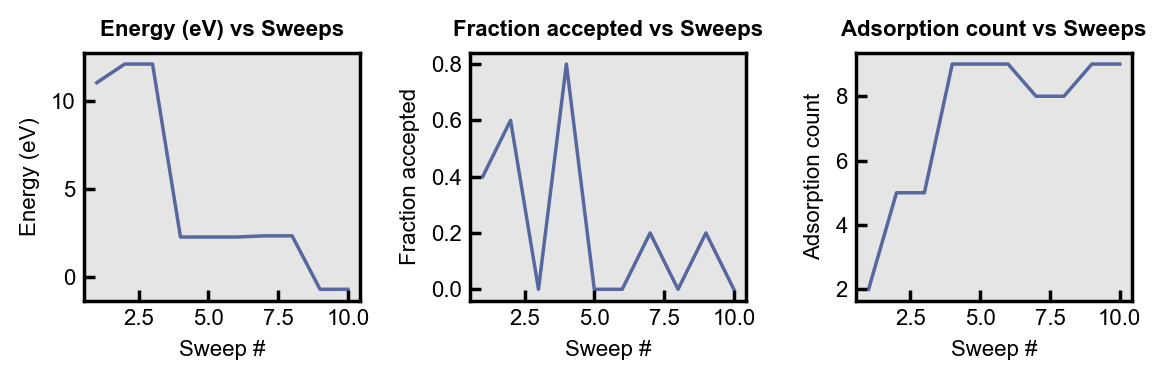

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [9]:
structures = results["history"]
with open("data/SrTiO3_001/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)